<a href="https://colab.research.google.com/github/jameskli/dengue_dynamics/blob/main/Dengue_Dynamics_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# IMPORTS 
# File I/O Imports
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
import gspread_dataframe as gd

# Data Analyis, Visualization Imports
import numpy as np
import pandas as pd
import random
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Sklearn
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# CONSTANTS

## User-run constants
* Set these constants before running

In [ ]:
# UNIVERSAL PARAMETERS
TEST_SIZE = 0.25
CROSS_VAL_FOLDS = 5
RANDOM_STATE = 42

# FEATURE IMPORTANCE (will drop features, and re-run analysis on dataset)
USE_FEATURE_IMPORTANCE = False

# Uses previous case's label as a feature (which means it cant generate competition output)
# So leave this False unless you really want to use it.
USE_PREV_CASES = False

# COMPETITION RESULT OUTPUT 
COMPETITION_RESULTS_OUTPUT_NAME = "competition-results"
EXPORT_RESULT_TO_GSHEET = False


## Data Scientist-defined Constants
* Mostly for reference only

In [ ]:
# FEATURE KEYS
ORIG_FEATURE_KEYS = ['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne',
                     'ndvi_nw','ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
                     'reanalysis_air_temp_k','reanalysis_avg_temp_k',
                     'reanalysis_dew_point_temp_k','reanalysis_max_air_temp_k',
                     'reanalysis_min_air_temp_k',
                     'reanalysis_precip_amt_kg_per_m2',
                     'reanalysis_relative_humidity_percent',
                     'reanalysis_sat_precip_amt_mm',
                     'reanalysis_specific_humidity_g_per_kg',
                     'reanalysis_tdtr_k','station_avg_temp_c',
                     'station_diur_temp_rng_c',
                     'station_max_temp_c','station_min_temp_c',
                     'station_precip_mm']
NUMERIC_FEATURE_KEYS = ['year', 'weekofyear', 'ndvi_ne', 'ndvi_nw',
                        'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm',
                        'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
                        'reanalysis_dew_point_temp_k',
                        'reanalysis_max_air_temp_k',
                        'reanalysis_min_air_temp_k',
                        'reanalysis_precip_amt_kg_per_m2',
                        'reanalysis_relative_humidity_percent',
                        'reanalysis_sat_precip_amt_mm',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_tdtr_k', 'station_avg_temp_c',
                        'station_diur_temp_rng_c', 'station_max_temp_c',
                        'station_min_temp_c', 'station_precip_mm']
TIME_FEATURE_KEYS = ['week_start_date']
DROP_FEATURE_KEYS = ['precipitation_amt_mm', 'reanalysis_air_temp_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']
CATEGORY_KEYS = ['city']

# added new feature, also week of year is now a category
PIPELINE_CATEGORY_KEYS = ['city', 'weekofyear', 'yearofdecade']  # if treating week and year as categories

PIPELINE_CATEGORY_KEYS_RF = ['city'] 
PIPELINE_NUMERIC_KEYS = ['reanalysis_avg_temp_k',
                        'reanalysis_dew_point_temp_k',
                        'reanalysis_max_air_temp_k',
                        'reanalysis_min_air_temp_k',
                        'reanalysis_precip_amt_kg_per_m2',
                        'reanalysis_relative_humidity_percent',
                        'reanalysis_sat_precip_amt_mm',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_tdtr_k']
PIPELINE_NUMERIC_KEYS_RF = []

# ndvi_xxx are already scaled to [-1.0,1.0], so excluding from pipeline
PIPELINE_PASSTHRU_KEYS = ['ndvi_ne', 'ndvi_nw','ndvi_se', 'ndvi_sw']

# if using RF, none of the numerical values need scaling, so passthru.
PIPELINE_PASSTHRU_KEYS_RF = ['reanalysis_avg_temp_k',
                        'reanalysis_dew_point_temp_k',
                        'reanalysis_max_air_temp_k',
                        'reanalysis_min_air_temp_k',
                        'reanalysis_precip_amt_kg_per_m2',
                        'reanalysis_relative_humidity_percent',
                        'reanalysis_sat_precip_amt_mm',
                        'reanalysis_specific_humidity_g_per_kg',
                        'reanalysis_tdtr_k', 'cos_weekofyear', 'cos_yearofdecade','ndvi_ne', 'ndvi_nw','ndvi_se', 'ndvi_sw']
PIPELINE_DROP_KEYS = ['year','week_start_date',  'weekofyear', 'yearofdecade']  #FOR REFERENCE ONLY, PIPELINE IMPLICITLY DROPS THESE

# LABEL KEYS
ORIG_LABEL_KEYS = ['city', 'year', 'weekofyear', 'total_cases'] 
NUMERIC_LABEL_KEYS = ['year','weekofyear','total_cases']
DROP_LABEL_KEYS = ['city', 'year','weekofyear']


# Helper Functions

## Basic Cleaning Data

In [ ]:
def clean_data(input_df, drop_keys=[], numeric_keys=[], cat_keys=[], time_keys=[]):
  """ takes a DF, drops drop_key columns, converts 
  numereric, time, and category keys appropriately
  categorical not yet implemented """

  new_df = input_df.copy()
  
  # Drop keys
  drop_key_list = intersection(new_df.keys(), drop_keys)
  new_df = new_df.drop(columns=drop_key_list)

  curr_key_list = new_df.keys()

  # Convert to numeric and time
  numeric_key_list = intersection(curr_key_list, numeric_keys)
  new_df[numeric_key_list] = new_df[numeric_key_list].apply(pd.to_numeric)

  time_key_list = intersection(curr_key_list, time_keys)
  new_df[time_key_list] = new_df[time_key_list].apply(pd.to_datetime)
  
  # Insert category processing --- placeholder, no processing performed
  cat_key_list = intersection(curr_key_list, cat_keys)
  
  return new_df

def intersection(lst1, lst2): 
  """ helper function only for clean_data
  Returns the intersection of two lists
  """
  return list(set(lst1) & set(lst2)) 

def clean_training_data(input_df, drop_keys=[], numeric_keys=[], cat_keys=[], time_keys=[]):
  """ Performs clean_data generally, but also imputes empty cells
  The cities were separated because imputing data using neighbouring rows does not make sense if not for the same city.
  """
  # First generically clean by dropping unneeded keys, converting numeric, time values etc
  raw_X = clean_data(input_df, drop_keys=drop_keys, numeric_keys=numeric_keys, cat_keys=cat_keys, time_keys=time_keys)

  # Separate out sj and iq first, then perform imputing, so that it doesnt accidentally use the other city's data for linear interpolation
  X_sj = clean_data(raw_X.loc[raw_X['city'] == 'sj'])
  X_sj = impute_empty_cells(X_sj) 

  X_iq = clean_data(raw_X.loc[raw_X['city'] == 'iq'])
  X_iq = impute_empty_cells(X_iq) 

  # final X to be used for further analysis
  basic_X = X_sj.append(X_iq)
  return basic_X

In [ ]:
def impute_empty_cells(input_df):
  """ Given a 1-column dataframe, fills the nulls or zeros with values that are linearly interpolated from adjacent rows
  Returns a 1-col dataframe.
  """
  out_df = input_df.copy()
  for column in input_df:
    # indices in the column which hard zeroes or NaN
    null_or_zero_indices = return_empty_cells_in_1d_array(input_df[column], missing_vals=[0])
    
    for index in null_or_zero_indices:
      min_index = input_df[column].index.values[0]
      max_index = input_df[column].index.values[len(input_df[column])-1]
      imputing_indices = return_indices_for_interpolation(index, min_index, max_index, null_or_zero_indices)
      
      imputed_value  = simple_linear_interpolation(input_df[column], index, imputing_indices)
      
      out_df.at[index,column] = imputed_value
      
  return out_df


def simple_linear_interpolation(input_df, index, imputing_indices):
  """Returns the y-value of a linear fit, given a 1-column df, the index of 
  the missing value and the indices of the known values to be used for the 
  linear fit
  """
  model = LinearRegression()
  
  X = np.asarray(imputing_indices).reshape(len(imputing_indices),1)
  y = input_df[imputing_indices].to_numpy().reshape(len(imputing_indices),1)

  model.fit(X, y)
  
  x_new = np.asarray(int(index)).reshape(1,1)
  y_new = model.predict(x_new)

  return y_new[0][0]

def return_empty_cells_in_1d_array(input_df, missing_vals=[]):
  """ given a 1-column df, return a list of the indices that are isna()
  can also optionally give a list of other missing values to search for
  eg: missing_vals =[0]
    """
  column_array = input_df
  missing_val_bool = column_array.isna()
  for val in missing_vals:
    missing_val_bool = missing_val_bool | (column_array == val)
  
  null_or_zero_indices = column_array[missing_val_bool].index.tolist() 
  return null_or_zero_indices

def return_indices_for_interpolation(index, min_index, max_index, null_or_zero_indices, values_to_interpolate=2):
  """ for a specific index of a specific missing value, the max and min search index, 
  and a list of the other indices of missing values, 
  return a list of indices which will be used for interpolation
  Can also set the # of values before and after to use in interpolation 
  eg values_to_interpolate=2  means 2 weeks before and 2 weeks after
  """

  index_list = []
  values_needed_left = 1
  values_needed_right = 1
  curr_index = index
  
  while (values_needed_left<= values_to_interpolate) and (curr_index >= min_index):
    if curr_index not in null_or_zero_indices:
      index_list.append(curr_index)
      values_needed_left +=1
    curr_index-=1
  curr_index = index
  while (values_needed_right<= values_to_interpolate) and (curr_index <= max_index):
    if curr_index not in null_or_zero_indices:
      index_list.append(curr_index)
      values_needed_right +=1
    curr_index+=1
  return index_list

## Custom Features

### Year of Decade Periodicity

In [ ]:
def output_yearofdecade(input_df):
  """ outputs year of decade, analogous to week of year
  requires the true year of the Monday of the given week
  first calculates the true year based on a Monday week start date 
  (handles end of year, eg week 52, 53 edge cases)
  """
  true_year = (input_df - pd.to_timedelta(input_df.dt.weekday, unit='D')).dt.year
  yearofdecade = true_year.mod(10).astype(int)
  return yearofdecade

## Pipeline

In [ ]:
def get_column_names_from_ColumnTransformer(column_transformer):
  """ Gets column names from Transformer.
  """ 
  col_name = []
  for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder' which we ignore, since those are dropped.
      raw_col_name = transformer_in_columns[2]
      if isinstance(transformer_in_columns[1],Pipeline): 
          transformer = transformer_in_columns[1].steps[-1][1]
      else:
          transformer = transformer_in_columns[1]
      try:
          names = transformer.get_feature_names()
      except AttributeError: # if no 'get_feature_names' function, use raw column name
          names = raw_col_name
      if isinstance(names,np.ndarray): 
          col_name += names.tolist()
      elif isinstance(names,list):
          col_name += names
      elif isinstance(names,str):
          col_name.append(names)
  return col_name

## Feature Importances

In [ ]:
def show_feature_importance(X,y,params_dict=None,most_important_n=-1, print_all=False):
  """ quick way to print out feature importances, using the RandomForest Regressor
  Can feed in a params_dict.
  """
  model = RandomForestRegressor()
  if params_dict is not None:
    model.set_params(**params_dict)
  model.fit(X,y)
  importances = list(zip(list(X), model.feature_importances_))
  sorted_importances = sorted(importances, key = lambda x: x[1]) 
  sorted_importances.reverse()
  sorted_importances_df = pd.DataFrame(sorted_importances, columns=["Feature","Importance"])
  sorted_importances_df.index+=1
  sorted_importances_df["Cumulative Importance"] = sorted_importances_df["Importance"].cumsum()
  if print_all or most_important_n > sorted_importances_df.shape[0]:
    with pd.option_context("display.max_rows", 1000):
      display(sorted_importances_df)
  else:
    with pd.option_context("display.max_rows", 1000):
      display(sorted_importances_df.head(most_important_n))

  feature_list, _ = zip(*sorted_importances)
  if most_important_n == -1 or most_important_n > len(feature_list):
    return list(feature_list)
  else:
    return list(feature_list[:most_important_n])

## Model Fittings

In [ ]:
def predictions_and_mae(estimator, X, y_true):
  """Returns the y-predictions and the mean absolute error, given estimator and X,y values
  Note that the y-predictions actually have to be converted to int afterwards for the competition but is not done here.
  """

  y_pred = estimator.predict(X)
  return y_pred, mean_absolute_error(y_true, y_pred)

## Gsheet I/O

In [ ]:
def create_df_from_gsheet(gsheet):
  """ import data from gsheet, re-label columns, and remove label-row"""
  output_df = pd.DataFrame(gsheet.get_all_values())
  output_df.columns = output_df.iloc[0]
  output_df = output_df.iloc[1:]
  return output_df

In [ ]:
def write_df_to_gsheet(sheet_name, input_df):
  """ write dataframe to gsheet, note that this writes to Gdrive's root folder and not to current path"""
  sh = gc.create(sheet_name)
  gd.set_with_dataframe(sh.sheet1, input_df)

# Preparatory Steps

## Import Data from Google Docs CSV Files --- enter Google auth code here!
* Input: 
  * Respective google sheets (assuming it's in the same path as this colab file)
* Actions: Convert to dataframes
* Output: Dataframes directly from the google sheets are called:
 * features_train_df
 * labels_train_df
 * features_competition_df
 * labels_competition_df

In [ ]:
# Obtain data from Google Sheet

auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

features_train_gsheet = gc.open('dengue_features_train').sheet1
labels_train_gsheet = gc.open('dengue_labels_train').sheet1
features_competition_gsheet = gc.open('dengue_features_test').sheet1
labels_competition_gsheet = gc.open('submission_format').sheet1

# Convert Google Sheet tabular data to df's
features_train_df = create_df_from_gsheet(features_train_gsheet)
labels_train_df = create_df_from_gsheet(labels_train_gsheet)
features_competition_df = create_df_from_gsheet(features_competition_gsheet)
labels_competition_df = create_df_from_gsheet(labels_competition_gsheet)


## Information about the Raw Data

### Exploring with Pandas

In [ ]:
features_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456 entries, 1 to 1456
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   city                                   1456 non-null   object
 1   year                                   1456 non-null   object
 2   weekofyear                             1456 non-null   object
 3   week_start_date                        1456 non-null   object
 4   ndvi_ne                                1456 non-null   object
 5   ndvi_nw                                1456 non-null   object
 6   ndvi_se                                1456 non-null   object
 7   ndvi_sw                                1456 non-null   object
 8   precipitation_amt_mm                   1456 non-null   object
 9   reanalysis_air_temp_k                  1456 non-null   object
 10  reanalysis_avg_temp_k                  1456 non-null   object
 11  reanalysis_dew_po

In [ ]:
features_train_df.sample(5)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
481,sj,1999,29,1999-07-23,0.1169,0.0494,0.2071143,0.1935286,96.36,299.85,299.8571429,296.8614286,301.9,298.5,66.52,83.91857143,96.36,18.32285714,2,26.7,5.471428571,31.1,21.7,56.2
270,sj,1995,26,1995-07-02,0.2319333,0.2115,0.2412286,0.2656857,2.04,300.68,300.8071429,296.7414286,302.7,298.7,13.7,79.38,2.04,18.20714286,2.757142857,29.21428571,6.342857143,33.9,24.4,15.8
561,sj,2001,6,2001-02-05,,-0.0056,0.1645,0.1619714,10.73,297.8771429,297.9857143,292.9814286,299.7,296.1,11.2,74.34428571,10.73,14.40857143,2.114285714,25,6.828571429,29.4,21.1,8.5
427,sj,1998,28,1998-07-09,-0.03095,0.0628,0.1886286,0.1695286,54.05,300.4528571,300.4357143,296.9242857,302.9,298.5,45.31,81.29,54.05,18.39142857,2.3,28.38571429,6.742857143,32.8,22.8,11.7
1386,iq,2009,8,2009-02-19,0.1887857,0.1594571,0.1568714,0.2029857,124.8,297.6857143,299.0142857,296.2542857,306.7,294.2,124,92.90571429,124.8,17.85285714,6.828571429,27.7,12.54,35,20.5,111.4


In [ ]:
features_train_df.describe()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456
unique,2,21,53,1049,1215,1366,1396,1389,1158,1177,601,1181,142,118,1040,1371,1158,1172,520,493,471,74,74,664
top,sj,2006,28,2003-05-28,,,,,0,,,,301.8,298,,,0,,2.357142857,,,32.8,23.9,0
freq,936,104,28,2,194,52,22,22,239,10,10,10,35,37,10,10,239,10,21,43,43,146,135,42


### Observations

* two cities, San Juan (SJ), Puerto Rico and Iquitos (IQ), Peru

**Training**
* SJ 1990 (wk 18)- 2008 (wk 17)
* IQ 2000 (wk 26) - 2010 (wk25)

**Test:**
* SJ 2008 (wk 18) - 2013 (wk 17)
* IQ 2010 (wk 26) - 2013 (wk26)

**Data Observations**
* Week 53 (end of year disparities), eg "1993 Wk 53" is actually 1992 Week 53 
* We suspect that the date some of the data is collected, is not the actual listed day.
* also most of the Wk 53 is actually missing all the data.
* there are 18 Wk53's in training and 5 Wk53's in testing
* there are blanks which need imputing
* there are also zero's which dont look realistic  and is likely just using '0' a defaulting value.
* for those with blanks or 0's, count the number of blanks, and split it before and after
* all testing data is in the future 
* a lot of data seems to be redundant (same definition, identical values)

**Actions Necessary**
* need to impute the blanks and zeros.
* suggested way to impute: do a linear fit using 2 weeks before and 2 weeks after
* remove duplicates
* see Basic Cleaning for Further Details

## Basic Cleaning
* Input:
  * all respective dataframes 
* Actions:
 * Converts cell (objects) appropriately to time, numeric values.
 * Perform imputing on missing and zero values
 * Drop duplicates
* Outputs:
 * Non-competition features and labels are called **basic_X** and **basic_y**
 * Competition features and labels are called **competition_basic_X** and **competition_basic_y**

* Note:
  * **competition__[X,y]** data are being processed identically and in parallel to **[X,y]**, so that we can proceed to analyze competition data after model is selected.

### Detailed Actions
* converted **Week_start_date** to time internally
* removed **precipitation_amt_mm** because it was identical to **reanalysis_sat_precip_amt_mm**
* removed **reanalysis_air_temp_k** because it was essentially the same as **reanalysis_avg_temp_k** (average of 0.5 Kelvin diff)
* arbitrarily kept all "**reanalysis___XXX**"" and dropped all the other equivalent columns, (XXX = max, min, average, diurnal temp, precipation)
```
DROP_FEATURE_KEYS = ['precipitation_amt_mm', 'reanalysis_air_temp_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']
```
* imputed missing values using the next available 2 weeks (eg 2 rows before and 2 rows after) using a linear fit
* this probably is fine for everything, except, there are about 15 rows of **nvdi_XX** missing
 * Again, this is only a 15-row issue in the long run, so should not detrimentally affect the results (and we feel is a better impute option than median)
* made the assumption that any 0-values needs to be interpolated. As these are weekly values, it is very strange for there to be absolutely no precipitation in a given week, especially given the neighbouring week's values are non-zero and not near zero either.

### Cleaning Code

In [ ]:
basic_X = clean_training_data(features_train_df, drop_keys=DROP_FEATURE_KEYS, numeric_keys=NUMERIC_FEATURE_KEYS, time_keys=TIME_FEATURE_KEYS)
basic_y = clean_data(labels_train_df, numeric_keys=NUMERIC_LABEL_KEYS)

competition_basic_X = clean_training_data(features_competition_df, drop_keys=DROP_FEATURE_KEYS, numeric_keys=NUMERIC_FEATURE_KEYS, time_keys=TIME_FEATURE_KEYS)
competition_basic_y = clean_data(labels_competition_df, numeric_keys=NUMERIC_LABEL_KEYS)

# Visualizations

Text(0.5, 1.0, 'Total Number of Cases by City')

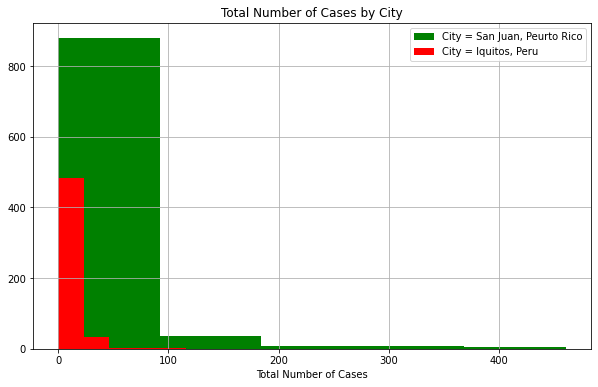

In [ ]:
plt.figure(figsize=(10,6))
basic_y[basic_y['city']=='sj']['total_cases'].hist(bins=5,color='green', label='City = San Juan, Peurto Rico')
basic_y[basic_y['city']=='iq']['total_cases'].hist(bins=5,color='red',label='City = Iquitos, Peru')
plt.legend()
plt.xlabel('Total Number of Cases')
plt.title('Total Number of Cases by City')

In [ ]:
visual_df_sj = basic_y[basic_y['city'] == 'sj']
visual_df_iq = basic_y[basic_y['city'] == 'iq']

Text(0.5, 1.0, 'Total Cases: San Juan, Peurto Rico')

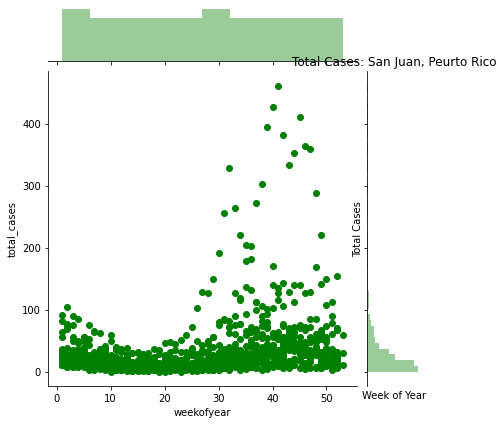

In [ ]:
sns.jointplot(x='weekofyear',y='total_cases',data=visual_df_sj,color='green')
plt.xlabel('Week of Year')
plt.ylabel('Total Cases')
plt.title('Total Cases: San Juan, Peurto Rico')

Text(0.5, 1.0, 'Total Cases: Iquitos, Peru')

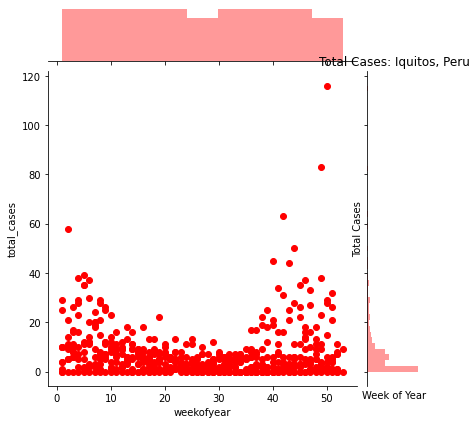

In [ ]:
sns.jointplot(x='weekofyear',y='total_cases',data=visual_df_iq,color='red')
plt.xlabel('Week of Year')
plt.ylabel('Total Cases')
plt.title('Total Cases: Iquitos, Peru')

# Custom Feature Engineering

* Input: 
  * all dataframes after basic cleaning
* Actions:
 * Adds new columns
 * Deletes old columns
* Outputs:
 * Non-competition features and labels are called **X** and **y**
 * Competition features and labels are called **competition_X** and **competition_y**

In [ ]:
X = basic_X.copy()
y = basic_y  #.copy()  (no further steps occuring to y's)

competition_X = competition_basic_X.copy()
competition_y = competition_basic_y #.copy()  (no further steps occuring to y)

## Generate "yearofdecade" periodicity
*  Create a column that represents long-term periodicity, using the year of decade (essentially the last digit of the year)
* Functions as the long-term analogue of **weekofyear**
* this is meant to handle the time-series problem, where:
  * training data cant be randomly sampled, if there is some dependence on past data
  * all competition test data is in the future

In [ ]:
X['yearofdecade'] = output_yearofdecade(basic_X['week_start_date'])
competition_X['yearofdecade'] = output_yearofdecade(basic_X['week_start_date'])

## Generate other Features

In [ ]:
# Test, trying to handle the periodicity myself by using Cosines of the year and week

max_year_of_decade = 9.0
max_weekofyear = 53.0
X['cos_yearofdecade'] = np.cos(2*np.pi*X['yearofdecade']/max_year_of_decade)
competition_X['cos_yearofdecade'] = np.cos(2*np.pi*competition_X['yearofdecade']/max_year_of_decade)

X['cos_weekofyear'] = np.cos(2*np.pi*X['weekofyear']/max_weekofyear)
competition_X['cos_weekofyear'] = np.cos(2*np.pi*competition_X['weekofyear']/max_weekofyear)



## Generate features based on Look back

In [ ]:
if USE_PREV_CASES:
  X['previous_cases'] = y['total_cases']
  X['previous_cases']= X['previous_cases'].shift(periods=1)
  X.at[1,'previous_cases']=X['previous_cases'][2]

In [ ]:
X.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,yearofdecade,cos_yearofdecade,cos_weekofyear
1,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,0,1.0,-0.533823
2,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,0,1.0,-0.630088
3,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,0,1.0,-0.717507
4,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,0,1.0,-0.794854
5,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,0,1.0,-0.861044


# Pipeline
* Input: all dataframes after feature engineering
* Actions:
 * Feed throu a pipeline
* Outputs:
 * Non-competition features and labels are called **X_prep** and **y_prep**
 * Competition features and labels are called **competition_X_prep** and **competition_y_prep**

In [ ]:

cat_attribs = PIPELINE_CATEGORY_KEYS_RF
# num_attribs = PIPELINE_NUMERIC_KEYS  # if num_attribs need scaling
num_attribs = PIPELINE_NUMERIC_KEYS_RF # this is actually empty, because RF Numerics dont need scaling.
passthru_attribs = PIPELINE_PASSTHRU_KEYS_RF.copy()

if USE_PREV_CASES:
  passthru_attribs.append('previous_cases')
drop_attribs = PIPELINE_DROP_KEYS  # for reference only, nothing is being done to ['year','week_start_date'] so it will be dropped

full_pipeline = ColumnTransformer([
                                   ("cat",OneHotEncoder(sparse=False, drop='first'), cat_attribs),
                                   ("num", StandardScaler(), num_attribs),
                                   ("passthru",'passthrough', passthru_attribs),
                                   ],
                                  remainder='drop'
                                  )
full_pipeline.fit(X)
pipeline_cols = get_column_names_from_ColumnTransformer(full_pipeline)

In [ ]:
# ensures X_prep remains a dataframe 
X_prep = pd.DataFrame(full_pipeline.transform(X), columns=pipeline_cols)
y_prep = y # no need to deep copy, no changes were made
X_prep.index = np.arange(1, len(X_prep) + 1)

if not USE_PREV_CASES:
  competition_X_prep = pd.DataFrame(full_pipeline.transform(competition_X), columns=pipeline_cols)
  competition_X_prep.index = np.arange(1, len(competition_X_prep) + 1)
  competition_y_prep = competition_y #no need to deep copy, no changes were made



In [ ]:
X_prep.shape, y_prep.shape

((1456, 16), (1456, 4))

In [ ]:
X_prep.sample(5)
# x0_  is SJ or not SJ


,x0_sj,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,cos_weekofyear,cos_yearofdecade,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw
912,1.0,300.685714,295.838571,302.6,298.2,10.3,75.350000,15.25,17.295714,2.257143,0.582979,0.173648,-0.251700,-0.048600,0.205171,0.172883
236,1.0,300.050000,295.845714,301.9,298.3,15.6,78.685714,5.41,17.264286,2.328571,0.482792,-0.939693,0.133644,0.121452,0.221068,0.223399
793,1.0,300.892857,296.981429,303.1,298.8,31.9,79.481429,39.49,18.481429,2.442857,-0.956401,-0.939693,-0.066500,-0.021000,0.235829,0.233343
190,1.0,298.585714,294.160000,300.8,296.2,28.6,76.854286,14.82,15.571429,2.457143,0.937420,-0.500000,-0.290200,-0.067667,0.168286,0.080000
370,1.0,299.042857,295.978571,300.6,297.9,41.7,83.485714,118.35,17.368571,1.971429,-0.915146,0.173648,0.055700,0.088950,0.184157,0.162357


# Train Test Split
* Input: data after pipeline preparation (non competition) **X_prep** and **y_prep**
* Actions:
 * Split into train and test (competition_ data is ignored)
* Outputs:
 * Non-competition train, test features and labels are called **X_train**, **y_train**, **X_test** and **y_test**
* from now on, y_train and y_test only contains total cases (1 col)


In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X_prep,y_prep['total_cases'],test_size=TEST_SIZE,random_state=RANDOM_STATE)

In [ ]:
X_prep.shape,y_prep.shape

((1456, 16), (1456, 4))

In [ ]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((1092, 16), (364, 16), (1092,), (364,))

# Feature Importances
* This is an optional step, mainly to look at the rankings of engineered features.
* Input: data after split (non competition) **X_train** and **y_train**
* Actions:
 * Prints out the n most important features, using a RF Regressor
 * you can feed in a params dictionary using params_dict={'feature':value} notation
 * also returns a list of feature names of the n most important
 * Setting most_important_n = -1 or leaving it out, implies the entire list
 * Setting print_all=True prints the full feature ranking. False or leaving it out prints the n-most important.
* Outputs:
 * a list of the n-most important features, **most_important_feature_list**


In [ ]:
prelim_important_feature_list = show_feature_importance(X_train,y_train, most_important_n=15, print_all=False, params_dict={'n_estimators':100})
prelim_important_feature_list

,Feature,Importance,Cumulative Importance
1,ndvi_sw,0.189166,0.189166
2,reanalysis_min_air_temp_k,0.136442,0.325607
3,ndvi_nw,0.125313,0.450920
4,cos_weekofyear,0.089926,0.540846
5,cos_yearofdecade,0.089849,0.630695
6,reanalysis_dew_point_temp_k,0.053899,0.684594
7,reanalysis_sat_precip_amt_mm,0.048968,0.733562
8,reanalysis_specific_humidity_g_per_kg,0.042117,0.775679
9,reanalysis_tdtr_k,0.040936,0.816615
10,reanalysis_precip_amt_kg_per_m2,0.037354,0.853969


['ndvi_sw',
 'reanalysis_min_air_temp_k',
 'ndvi_nw',
 'cos_weekofyear',
 'cos_yearofdecade',
 'reanalysis_dew_point_temp_k',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_avg_temp_k',
 'ndvi_se',
 'ndvi_ne',
 'reanalysis_max_air_temp_k']

# Model Fitting

## Preliminary broad model search
* **Note** that this was only a broad-based search. In initial exploratory analyses, **Pipeline scaled the numerical values**, however since it was not necessary for RandomForest (our final chose of model), these right now are running non-scaled numerica data, and may not give optimal result.

In [ ]:
tree_reg = DecisionTreeRegressor(max_depth=4)

forest_reg = RandomForestRegressor(random_state=RANDOM_STATE)
forest_reg.fit(X_train, y_train)

lin_reg = LinearRegression()

lin_svm_reg = LinearSVR()
svr_reg = SVR()

In [ ]:
# Cross validate
tree_reg_scores = cross_val_score(tree_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("Decision Tree score:", tree_reg_scores)

forest_reg_scores = cross_val_score(forest_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("Random Forest score: ", forest_reg_scores)

lin_reg_scores = cross_val_score(lin_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("Linear Reg score: ", lin_reg_scores)

lin_svm_reg_scores = cross_val_score(lin_svm_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("Linear SVM score: ", lin_svm_reg_scores)

svr_reg_scores = cross_val_score(svr_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("SVR score: ", svr_reg_scores)


Decision Tree score: [-14.80767585 -21.10423256 -19.42458853 -15.67180681 -14.98199479]
Random Forest score:  [-16.56557078 -18.22415525 -16.71844037 -13.63376147 -13.61619266]
Linear Reg score:  [-20.71414165 -20.40224411 -20.13015454 -19.0308358  -17.41662138]


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

Linear SVM score:  [-27.55935093 -22.48188076 -25.87151226 -16.73328111 -22.15754339]
SVR score:  [-18.69372582 -20.91744305 -21.30452375 -16.13707533 -16.37343949]


In [ ]:
y_pred = forest_reg.predict(X_train)
forest_reg_mae = mean_absolute_error(y_train, y_pred)

y_pred, y_train
print(forest_reg_mae)

5.587591575091575


## Support Vector
* Note that this was only part of an exploratory analyses, and when utilized, Pipeline scaled most numerical values, however since it was not necessary for RandomForest (our final chose of model), these right now are running non-scaled numerica data, and may not give optimal result.

### Base Model

In [ ]:
svr_reg = SVR()
svr_reg_scores = cross_val_score(svr_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("SVR score: ", svr_reg_scores)

SVR score:  [-18.69372582 -20.91744305 -21.30452375 -16.13707533 -16.37343949]


In [ ]:
svr_reg.fit(X_train, y_train)
print("The SVM's MAE on training data is:",  predictions_and_mae(svr_reg, X_train, y_train)[1])

The SVM's MAE on training data is: 18.602282008168682


### Grid Search

In [ ]:
sv_param_grid = {'kernel': ['linear','rbf','sigmoid'],
                 'tol': [0.0001, 0.001, 0.01, 0.1],
                 'gamma': ['scale','auto'],
                 'degree': [2,3]
                 }

sv_grid_search = GridSearchCV(SVR(), sv_param_grid, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error', return_train_score=True)
sv_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'degree': [2, 3], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf', 'sigmoid'],
                         'tol': [0.0001, 0.001, 0.01, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=0)

### Grid Search Results

In [ ]:
sv_grid_search.best_params_

{'degree': 2, 'gamma': 'scale', 'kernel': 'linear', 'tol': 0.1}

In [ ]:
sv_grid_search.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.1, verbose=False)

The grid-search optimized random forest model's MAE on training data is: 16.237814780820795


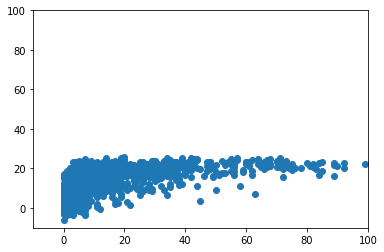

In [ ]:
sv_grid_train_pred, sv_mae_grid_train = predictions_and_mae(sv_grid_search.best_estimator_, X_train, y_train)
print("The grid-search optimized random forest model's MAE on training data is:", sv_mae_grid_train )

plt.scatter(x=y_train, y=sv_grid_train_pred)
plt.xlim([-10,100])
plt.ylim([-10,100])
plt.show()

## Random Forest

### Base Model

In [ ]:
# Creating and fitting the model with 10 trees
rf_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_STATE, criterion='mae')
rf_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
rf_reg_scores = cross_val_score(rf_reg, X_train, y_train, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error')
print("Random Forest score: ", rf_reg_scores)

Random Forest score:  [-20.3760274  -17.69634703 -19.98004587 -16.11284404 -17.09724771]


In [ ]:
print("The random forest model's MAE on training data is:",  predictions_and_mae(rf_reg, X_train, y_train)[1])

The random forest model's MAE on training data is: 6.9259615384615385


### Grid Search

***Notes***


---



*   **n_estimators** is the number of trees in the RF. We will arbitarily try 2, 4, 8 and 10 trees.


---


*   **max_features** is the number of features considered for splitting at each leaf node. We will arbitarily try: 4, 8, and 12.
(https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

***Other Notes***

---
*   Since we are trying **four** different n_estimators (2, 4, 8, 10) with **three** different numbers of max_features, we have a combination of **twelve** hyperparameters
---

*   **Bootstrapping** is a resampling technique used to estimate statistics on a population by sampling a dataset with replacement. We will also try **twelve** combinations with bootstrap set to False.

---

*   Our hyperparameters will be trained across 5 folds (i.e., cross validation = 5), which means we will have 120 rounds of training [(12 original + 12 bootstrapping)*5]



In [ ]:
max_features = int(len(X_train.keys()))
half_max_features = int(round(0.5*max_features))
quarter_max_features = int(round(0.25*max_features))

In [ ]:
rf_param_grid = {'n_estimators': [50, 100, 200,300,400,500],
                 'bootstrap': [True, False],
                 'max_features': [quarter_max_features, half_max_features, max_features],
                 #'max_features': [2,4,6,8,10,12,14,16],
                 'min_samples_leaf': [2,3,4,5,10],
                 }

rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), rf_param_grid, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error', return_train_score=True)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

### Grid Search Results

In [ ]:
rf_grid_search.best_params_

{'bootstrap': False,
 'max_features': 8,
 'min_samples_leaf': 3,
 'n_estimators': 500}

In [ ]:
rf_grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

The grid-search optimized random forest model's MAE on training data is: 3.848423260073256


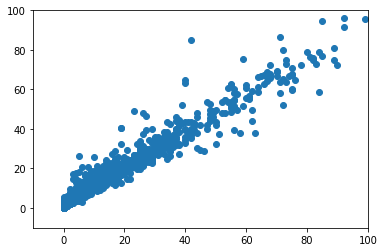

In [ ]:
rf_grid_train_pred, mae_grid_train = predictions_and_mae(rf_grid_search.best_estimator_, X_train, y_train)
print("The grid-search optimized random forest model's MAE on training data is:", mae_grid_train )

plt.scatter(x=y_train, y=rf_grid_train_pred)
plt.xlim([-10,100])
plt.ylim([-10,100])
plt.show()

### Randomized Seach

In [ ]:
rnd_max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
rnd_max_depth.append(None)

rf_param_rnd = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
                'bootstrap': [True, False],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [1, 2, 3, 4, 5,6,7,8,9,10,20,30],
                'max_depth': rnd_max_depth,
                'min_samples_split': [2, 3, 4, 5, 6, 8, 10,15],
                
                 }

rf_rnd_search = RandomizedSearchCV(RandomForestRegressor(random_state=RANDOM_STATE), rf_param_rnd, cv=CROSS_VAL_FOLDS, scoring='neg_mean_absolute_error', return_train_score=True)
rf_rnd_search.fit(X_train, y_train)

print(rf_rnd_search.best_params_)
_, rnd_mae_grid_train = predictions_and_mae(rf_rnd_search.best_estimator_, X_train, y_train)
print("The grid-search optimized random forest model's MAE on training data is:", rnd_mae_grid_train )


_, rnd_test_mae = predictions_and_mae(rf_rnd_search.best_estimator_, X_test, y_test)
print("The best model's MAE on test data is:",rnd_test_mae)

{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}
The grid-search optimized random forest model's MAE on training data is: 6.028276686276686
The best model's MAE on test data is: 17.28168084395763


## Best Model, Parameters, and Estimator
* Assign the best model from the models and searches above here.
* Input: 
  * **model's skitlearn name**, **___.best_params_** and **___.best_estimator_**
  * Using **X_test, y_test** for looking how it does on test data.
* Actions:
 * Assign best parameters and best estimators
* Outputs:
 * **best_model**, **best_estimator**, **best_params**
 * For reference: Running the best_estimator on holdout test data (eg **X_test**)


In [ ]:
# Change this if rf_grid was not the best choice here
best_model_name = RandomForestRegressor
best_estimator = rf_grid_search.best_estimator_
best_params = rf_grid_search.best_params_
best_param_grid = rf_param_grid  # Only to be used if re-doing feature importance (below)

### Best Estimator's Performance on Test Data

The best model's MAE on test data is: 16.00112335164835


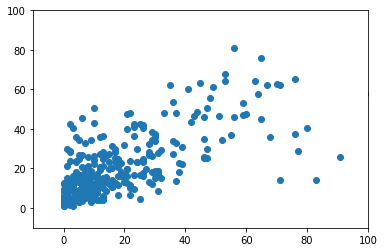

In [ ]:
y_test_pred, test_mae = predictions_and_mae(best_estimator, X_test, y_test)

print("The best model's MAE on test data is:",test_mae)

plt.scatter(x=y_test, y=y_test_pred)
plt.xlim([-10,100])
plt.ylim([-10,100])
plt.show()

## Feature Importance Revisited

### Re-run feature importances

Re-run Feature importance. Try to see if using less features will help the overfitting.

In [ ]:
# This shows that approx n=12 features suffices for >90% of the importance.
most_important_feature_list=show_feature_importance(X_train,y_train, most_important_n=12, print_all=True, params_dict=best_params)

,Feature,Importance,Cumulative Importance
1,ndvi_sw,0.199906,0.199906
2,ndvi_nw,0.128117,0.328023
3,cos_yearofdecade,0.118700,0.446723
4,cos_weekofyear,0.093200,0.539924
5,reanalysis_min_air_temp_k,0.091278,0.631202
6,reanalysis_dew_point_temp_k,0.060255,0.691456
7,reanalysis_specific_humidity_g_per_kg,0.053364,0.744820
8,reanalysis_tdtr_k,0.045731,0.790551
9,ndvi_se,0.041693,0.832244
10,ndvi_ne,0.032928,0.865172


### Feature Optimized Best Model


* Using the most_important_feature_list and the best model, re-run the entire analyis
* needed to create new X,y train,test, competitonwith dropped unimportant features
* needed to run train /test split
* ran the grid_search on train
* did some output, analogous to what was one after "Best Model"

The feature optimized best model grid-search's MAE on training data is: 2.060927960927961


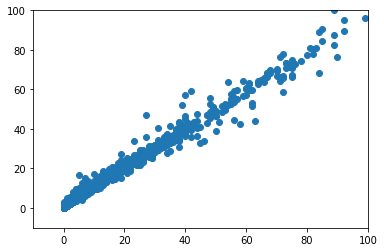

The best model's MAE on test data is: 15.766132478632482


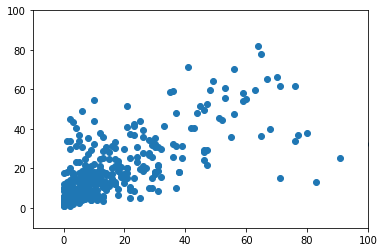

In [ ]:
# Features 
feature_opt_passthru_attribs = most_important_feature_list

# Pipeline
feature_opt_pipeline = ColumnTransformer([
                                          ("passthru",'passthrough', feature_opt_passthru_attribs),
                                          ],
                                         remainder='drop'
                                         )
feature_opt_pipeline.fit(X_prep)
feature_opt_pipeline_cols = get_column_names_from_ColumnTransformer(feature_opt_pipeline)


feature_opt_X_prep = pd.DataFrame(feature_opt_pipeline.transform(X_prep), columns=feature_opt_pipeline_cols)
feature_opt_X_prep.index = np.arange(1, len(feature_opt_X_prep) + 1)
feature_opt_y_prep = y # no need to deep copy, no changes were made

if not (USE_PREV_CASES):
  feature_opt_competition_X_prep = pd.DataFrame(feature_opt_pipeline.transform(competition_X_prep), columns=feature_opt_pipeline_cols)
  feature_opt_competition_y_prep = competition_y #no need to deep copy, no changes were made

# Train Test Split
feature_opt_X_train, feature_opt_X_test, feature_opt_y_train, feature_opt_y_test = train_test_split(feature_opt_X_prep,feature_opt_y_prep['total_cases'],test_size=TEST_SIZE,random_state=RANDOM_STATE)

# Model Fitting
feature_opt_model_name = best_model_name
max_features = int(len(feature_opt_X_train.keys()))
half_max_features = int(round(0.5*max_features))
quarter_max_features = int(round(0.25*max_features))


feature_opt_param_grid = {'n_estimators': [50, 100, 200,300],
                 'bootstrap': [False],
                 'max_features': [quarter_max_features, half_max_features, max_features],
                 'min_samples_leaf': [2,3,4],
                 }

feature_opt_grid_search =  GridSearchCV(feature_opt_model_name(random_state=RANDOM_STATE), feature_opt_param_grid, cv=CROSS_VAL_FOLDS, scoring='neg_mean_squared_error', return_train_score=True)
feature_opt_grid_search.fit(feature_opt_X_train, feature_opt_y_train)

feature_opt_estimator = feature_opt_grid_search.best_estimator_
feature_opt_params = feature_opt_grid_search.best_params_

feature_opt_grid_train_pred, feature_opt_mae_grid_train = predictions_and_mae(feature_opt_grid_search.best_estimator_, feature_opt_X_train, feature_opt_y_train)
print("The feature optimized best model grid-search's MAE on training data is:", feature_opt_mae_grid_train )

plt.scatter(x= feature_opt_y_train, y= feature_opt_grid_train_pred)
plt.xlim([-10,100])
plt.ylim([-10,100])
plt.show()

feature_opt_y_test_pred, feature_opt_test_mae = predictions_and_mae(feature_opt_grid_search.best_estimator_, feature_opt_X_test, feature_opt_y_test)

print("The best model's MAE on test data is:",feature_opt_test_mae)
plt.scatter(x= feature_opt_y_test, y= feature_opt_y_test_pred)
plt.xlim([-10,100])
plt.ylim([-10,100])
plt.show()

## Final Estimator
* Use the the best parameters and create the final estimator using the full X data.

**INPUT**
* Input:
 * **best_model_name**, **best_params** (or feature optimized ones)
 * **X_prep**,**y_prep** (or feature optimized ones with dropped features)
* Actions:
 * Does a Fit to create the final_estimator
* Outputs:
 * **final_estimator**
 * For reference: Running the final_estimator on full training data, eg **X_prep** and **y_prep['total_cases']** (or feature dropped-version)


In [ ]:
if USE_FEATURE_IMPORTANCE:
  final_model_name = feature_opt_model_name
  final_params = feature_opt_params
  final_X_prep = feature_opt_X_prep
  final_y_prep = feature_opt_y_prep
  if not USE_PREV_CASES:
    final_competition_X_prep = feature_opt_competition_X_prep
    final_competition_y_prep = feature_opt_competition_y_prep
else:
  final_model_name = best_model_name
  final_params = best_params
  final_X_prep = X_prep
  final_y_prep = y_prep
  if not USE_PREV_CASES:
    final_competition_X_prep = competition_X_prep
    final_competition_y_prep = competition_y_prep

In [ ]:

final_model = final_model_name(**final_params)
final_estimator = final_model.fit(final_X_prep,final_y_prep['total_cases'])

## Final Estimator's Performance on Full Training Data

The final model's MAE on full training data is: 3.969370695970691


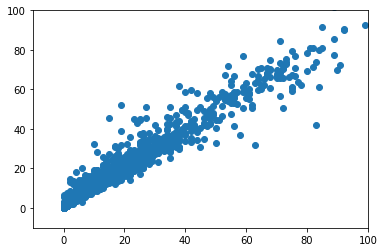

In [ ]:
y_full_train_pred, full_train_mae = predictions_and_mae(final_estimator, final_X_prep,final_y_prep['total_cases'])
print("The final model's MAE on full training data is:",  full_train_mae)

plt.scatter(x=final_y_prep['total_cases'], y=y_full_train_pred)
plt.xlim([-10,100])
plt.ylim([-10,100])
plt.show()

# Analyze Competition Results
* Generate the competition submission using the Final Model
* Input: 
  * **final_estimator**, **competition_X_prep** and **competition_y_prep**  
* Actions:
 * Generate the predictions of total cases using
* Outputs:
 * **y_competition_pred**
 * intermediate: **submission_df** (dataframe in the format of the submission output)
 * final: [Optional] GoogleSheets export to submit to DataDriven.Org


## Use Final Estimator on Competition Data

In [ ]:
if not USE_PREV_CASES:
  y_competition_pred,_ = predictions_and_mae(final_estimator, final_competition_X_prep, final_competition_y_prep['total_cases'])


## Generate Submission Format

In [ ]:
submission_df = competition_y.copy()
if not USE_PREV_CASES:
  submission_df['total_cases'] = y_competition_pred
  submission_df['total_cases'] = submission_df['total_cases'].astype(int)

In [ ]:
submission_df

,city,year,weekofyear,total_cases
1,sj,2008,18,9
2,sj,2008,19,11
3,sj,2008,20,19
4,sj,2008,21,18
5,sj,2008,22,18
...,...,...,...,...
412,iq,2013,22,3
413,iq,2013,23,1
414,iq,2013,24,1
415,iq,2013,25,1


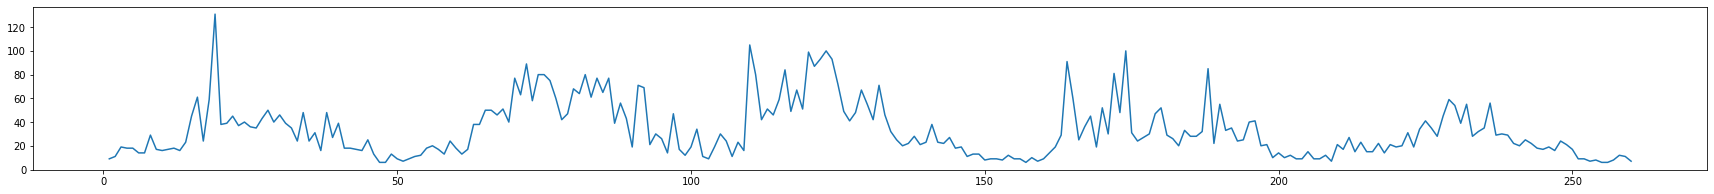

In [ ]:
#prediction for city SJ submission
subm_sj = submission_df[submission_df['city']=='sj']
plt.figure(figsize=(30,3))
plt.plot(subm_sj.index, subm_sj['total_cases'])
plt.show()

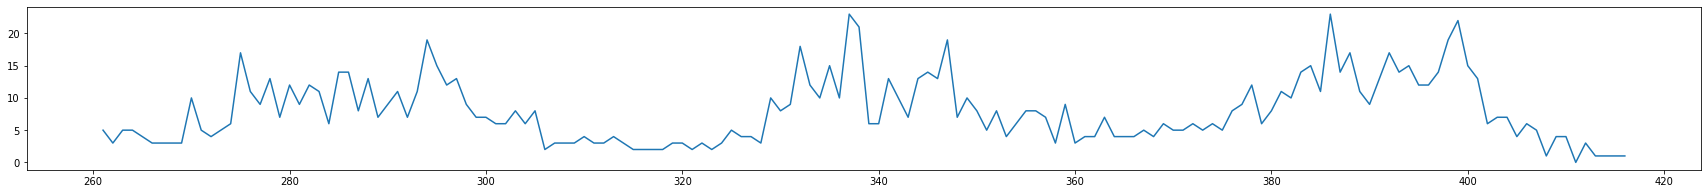

In [ ]:
#prediction for city IQ submission
subm_iq = submission_df[submission_df['city']=='iq']
plt.figure(figsize=(30,3))
plt.plot(subm_iq.index, subm_iq['total_cases'])
plt.show()

## Write to Google Sheet

Note that this writes to your Google Drive's root folder

In [ ]:
if EXPORT_RESULT_TO_GSHEET:
  write_df_to_gsheet(COMPETITION_RESULTS_OUTPUT_NAME,submission_df)

# Bonus Section
* Use the predictions above to generate labels (cases) without relying on previous week's cases (lookback), and feed it into a 2nd model that was trained to use previous week's labels.
## Steps
* train a 2nd model that uses lookback (Model 2)
* use the competition predictions above (y_competition_pred from Model 1)
* shift it by 1 week and merge with the X to generate a new X
* train a model using this new X (Model 2)
* Now predict new y's after Model 2

### Train the Lookback Model using the full training set (no split)

In [ ]:
lookback_train_X = X_prep.copy()
lookback_train_y = y_prep

lookback_train_X.index  = np.arange(1, len(lookback_train_X) + 1)
lookback_train_X['previous_cases'] = lookback_train_y['total_cases']
lookback_train_X['previous_cases']= lookback_train_X['previous_cases'].shift(periods=1)
lookback_train_X.at[1,'previous_cases']=lookback_train_X['previous_cases'][2]


# Model Fitting
lookback_model_name = best_model_name
max_features = int(len(lookback_train_X.keys()))
half_max_features = int(round(0.5*max_features))
quarter_max_features = int(round(0.25*max_features))

lookback_param_grid = {'n_estimators': [50, 100, 200,300],
                 'bootstrap': [False],
                 'max_features': [quarter_max_features, half_max_features, max_features],
                 'min_samples_leaf': [2,3,4],
                 }

lookback_grid_search =  GridSearchCV(lookback_model_name(random_state=RANDOM_STATE), lookback_param_grid, cv=CROSS_VAL_FOLDS, scoring='neg_mean_squared_error', return_train_score=True)
lookback_grid_search.fit(lookback_train_X, lookback_train_y['total_cases'])

lookback_estimator = lookback_grid_search.best_estimator_
lookback_params = lookback_grid_search.best_params_

### Create a test set for the Lookback model using predictions from RF earlier (no lookback)

In [ ]:
lookback_test_X = final_competition_X_prep.copy()
lookback_test_X.index  = np.arange(1, len(lookback_test_X) + 1)

lookback_test_X['previous_cases'] = y_competition_pred
lookback_test_X['previous_cases']= lookback_test_X['previous_cases'].shift(periods=1)
lookback_test_X.at[1,'previous_cases']=lookback_test_X['previous_cases'][2]

In [ ]:
lookback_test_X.head()

,x0_sj,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,cos_weekofyear,cos_yearofdecade,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,previous_cases
1,1.0,298.550000,294.527143,301.1,296.4,25.37,78.781429,78.6000,15.918571,3.128571,-0.533823,1.0,-0.018900,-0.018900,0.102729,0.091200,9.437000
2,1.0,298.557143,294.395714,300.8,296.7,21.83,78.230000,12.5600,15.791429,2.571429,-0.630088,1.0,-0.018000,-0.012400,0.082043,0.072314,9.437000
3,1.0,299.357143,295.308571,302.2,296.4,4.12,78.270000,3.6600,16.674286,4.428571,-0.717507,1.0,-0.001500,-0.002833,0.151083,0.091529,11.653600
4,1.0,299.728571,294.402857,303.0,296.9,2.20,73.015714,22.0375,15.775714,4.342857,-0.794854,1.0,-0.001675,-0.019867,0.124329,0.125686,19.340167
5,1.0,299.671429,294.760000,302.3,297.3,4.36,74.084286,0.7600,16.137143,3.542857,-0.861044,1.0,0.056800,0.039833,0.062267,0.075914,18.014367


### Perform the Fit and Compare Lookback vs Original Predictions

In [ ]:
lookback_competition_pred, lookback_vs_nolookback_mae = predictions_and_mae(lookback_estimator, lookback_test_X, y_competition_pred)

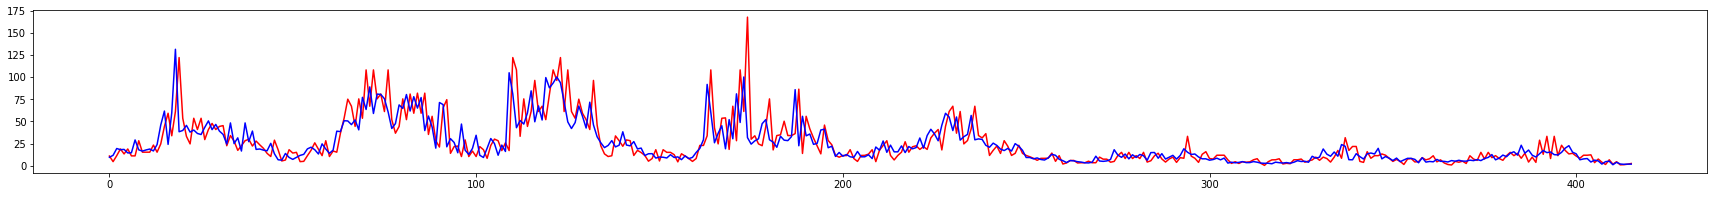

In [ ]:
plt.figure(figsize=(30,3))
plt.plot(lookback_competition_pred,'r')
plt.plot(y_competition_pred,'b')
plt.show()

In [ ]:
print("MAE between the two predictions is", lookback_vs_nolookback_mae)

MAE between the two predictions is 10.623932125686814


In [ ]:
lookback_submission_df = competition_y.copy()
lookback_submission_df['total_cases'] = lookback_competition_pred
lookback_submission_df['total_cases'] = lookback_submission_df['total_cases'].astype(int)

In [ ]:
case_comparison_df = submission_df.copy()
case_comparison_df['total_cases_lookback'] = lookback_submission_df['total_cases']

In [ ]:
case_comparison_df

,city,year,weekofyear,total_cases,total_cases_lookback
1,sj,2008,18,9,10
2,sj,2008,19,11,4
3,sj,2008,20,19,11
4,sj,2008,21,18,18
5,sj,2008,22,18,13
...,...,...,...,...,...
412,iq,2013,22,3,4
413,iq,2013,23,1,0
414,iq,2013,24,1,1
415,iq,2013,25,1,1


In [ ]:
# write_df_to_gsheet(COMPETITION_RESULTS_OUTPUT_NAME,submission_df)
# write_df_to_gsheet(COMPETITION_RESULTS_OUTPUT_NAME+"_with_lookback",lookback_submission_df)